# Chicago Divvy bike Analysis
**Download the data from Kaggle https://www.kaggle.com/datasets/gunnarn/chicago-bicycle-rent-usage**

In this project we will be diving into chicago divvy bike data from July 2021 to July 2022.
The main purpose of this analysis is to predict whether a casual rider would be likely to convert to a member. To get to this point we will be following these steps:

- Data Collection: We will dive ino the dataset that includes usage patterns of Cyclistic's bikes in Chicago. The data includes both casual riders and annual members, along with other attributes like trip duration, start and end times, start and end locations, type of bike and return/pickup locations.

- Data Cleaning and Preprocessing: This step will involve cleaning the data, handling missing values, outliers, and ensuring that the data is in a suitable format for analysis.
  
- Feature Engineering: In this step we will create new features that could better explain the variance in the data or are more suitable for prediction.

- Exploratory Data Analysis (EDA): We'll explore the data to find patterns and differences in usage between casual riders and annual members. We will be using statistical summaries and visualization techniques to uncover these insights.

- Model Building: We will select a few machine learning models that are appropriate for this kind of classification or regression problem. We'll train these models on the dataset to predict membership conversion or to classify user types.

- Model Evaluation: After training the models, we will evaluate them using suitable metrics to find the best-performing model.

- Insights and Recommendations: Based on the model results and EDA, we will draft insights and actionable recommendations on how to convert casual riders into annual members.

- Data Visualization: We will create professional visualizations that can be used in the executive summary to support our insights and recommendations.

## Loading the Data

Data is from July of 2021 to July of 2022

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import HeatMap
import webbrowser
import os

# Define the directory where the CSV files are stored
data_directory = './data/'

# List all CSV files in the data directory
csv_files = [file for file in os.listdir(data_directory) if file.endswith('.csv')]

# Initialize an empty list to hold all the dataframes
dataframes_list = []

# Iterate over the CSV files and load each one
for csv_file in csv_files:
    file_path = os.path.join(data_directory, csv_file)
    df = pd.read_csv(file_path)
    
    # Print the number of entries in the current file
    print(f"{csv_file}: {len(df)} entries")
    
    # Append the dataframe to the list
    dataframes_list.append(df)

# Concatenate all the dataframes into a single dataframe
combined_df = pd.concat(dataframes_list, ignore_index=True)

combined_df.info()
combined_df.dtypes


202205-divvy-tripdata.csv: 634858 entries
202109-divvy-tripdata.csv: 756147 entries
202107-divvy-tripdata.csv: 822410 entries
202206-divvy-tripdata.csv: 769204 entries
202111-divvy-tripdata.csv: 359978 entries
202112-divvy-tripdata.csv: 247540 entries
202203-divvy-tripdata.csv: 284042 entries
202202-divvy-tripdata.csv: 115609 entries
202201-divvy-tripdata.csv: 103770 entries
202110-divvy-tripdata.csv: 631226 entries
202207-divvy-tripdata.csv: 823488 entries
202204-divvy-tripdata.csv: 371249 entries
202108-divvy-tripdata.csv: 804352 entries
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6723873 entries, 0 to 6723872
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object

## Cleaning the Data

In this step we will: 
- Convert started_at and ended_at from string to datetime objects since currently they are strings.
- Handle missing values in start_station_name, start_station_id, end_station_name, end_station_id, end_lat, and end_lng
- Ensure that the ride_id is unique, or investigate any duplicates.

In [2]:
#converting columns to dates
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

#dropping columns missing values
df = df.dropna(subset=['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id'])
df.loc[:,'end_lat'] = df['end_lat'].ffill()
df.loc[:,'end_lng'] = df['end_lng'].ffill()

#making sure ride_id is unique by checking the number of records with unique id matches length of data
if df['ride_id'].nunique() == len(df):
    print("All ride IDs are unique.")
else:
    print("There are duplicate ride IDs.")


All ride IDs are unique.


### Feature engineering

Here I create the duration variable. I noticed we were getting a negative min value in the EDA, so I had to do some more data cleaning.
- Ensured all ride durations are positive
- Ensured all rides are under 24 hrs
- Eliminating outliers using IQR (Interquartile Range)

In [37]:
# calculating duration of ride
df['ride_duration'] = df['ended_at'] - df['started_at']

# Ensure all ride durations are positive (sanity check)
df = df[df['ride_duration'] >= pd.Timedelta(0)]

# Handle long durations (filter out anything over 24 hours)
max_duration = pd.Timedelta(hours=24)
df = df[df['ride_duration'] <= max_duration]

# Now handling outliers based on the IQR method
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['ride_duration'].quantile(0.25)
Q3 = df['ride_duration'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
outlier_low = Q1 - 1.5 * IQR
outlier_high = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['ride_duration'] >= outlier_low) & (df['ride_duration'] <= outlier_high)]

#extracting  temporal features
df['start_day_of_week'] = df['started_at'].dt.day_name()
df['start_month'] = df['started_at'].dt.month
df['start_hour'] = df['started_at'].dt.hour

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56786 entries, 398199 to 547227
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   ride_id                56786 non-null  object         
 1   rideable_type          56786 non-null  object         
 2   started_at             56786 non-null  datetime64[ns] 
 3   ended_at               56786 non-null  datetime64[ns] 
 4   start_station_name     56786 non-null  object         
 5   start_station_id       56786 non-null  object         
 6   end_station_name       56786 non-null  object         
 7   end_station_id         56786 non-null  object         
 8   start_lat              56786 non-null  float64        
 9   start_lng              56786 non-null  float64        
 10  end_lat                56786 non-null  float64        
 11  end_lng                56786 non-null  float64        
 12  member_casual          56786 non-null  object

## EDA

In this section we will:
- Set descriptive statistics: mean, median, mode, etc., for ride duration, distance, and temporal features.
- Compare usage patterns between casual riders and annual members using visualizations like histograms and time series plots.
- Perform correlation analysis to see if any features strongly correlate with the rider type.


In [4]:
##Distance calculation
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r


### Usage duration Analysis

Descriptive Statistics for Ride Duration:
count    595246.000000
mean         14.421153
std           9.571853
min           0.016667
25%           7.166667
50%          11.850000
75%          19.383333
max          45.983333
Name: ride_duration_minutes, dtype: float64
Mode: [7.23333333]
Descriptive Statistics for distance:
count    595246.000000
mean          2.234417
std           1.657020
min           0.000040
25%           1.078561
50%           1.766186
75%           2.915193
max          17.880537
Name: distance, dtype: float64
Mode: [1.02385686]

Descriptive Statistics for Temporal Features:
Mean Start Hour: 14.29316114681997
Median Start Hour: 15.0
Mode Start Hour: [17]


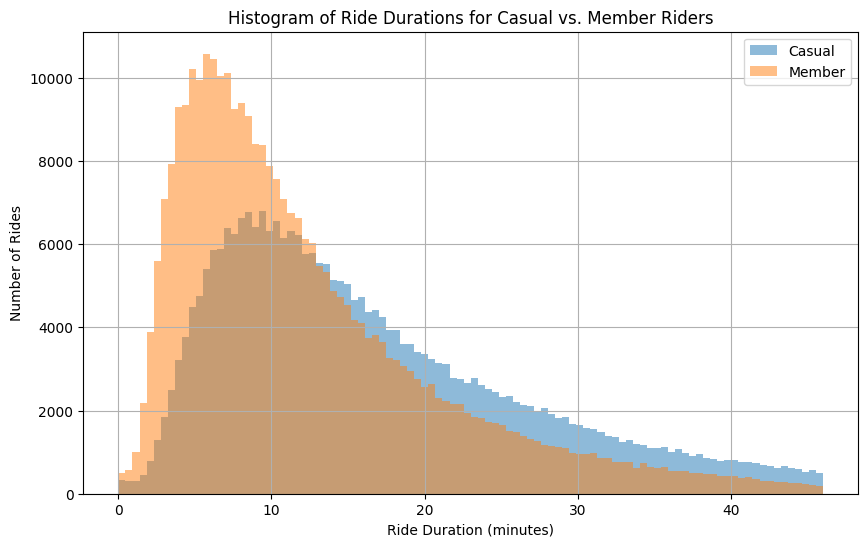

In [5]:
# Descriptive stats
df['ride_duration'].describe()

# Convert 'ride_duration' from Timedelta to total minutes
df['ride_duration_minutes'] = df['ride_duration'].dt.total_seconds() / 60.0
df['distance'] = df.apply(lambda row: haversine(row['start_lng'], row['start_lat'], row['end_lng'], row['end_lat']), axis=1)

# Filter out rides with a distance of 0
df = df[df['distance'] != 0]

# Descriptive statistics for ride_duration in minutes
print("Descriptive Statistics for Ride Duration:")
print(df['ride_duration_minutes'].describe())
print(f"Mode: {df['ride_duration_minutes'].mode().values}") # Mode can have multiple values

# Descriptive statistics for ride_duration in minutes
print("Descriptive Statistics for distance:")
print(df['distance'].describe())
print(f"Mode: {df['distance'].mode().values}") # Mode can have multiple values

# Descriptive statistics for temporal features
print("\nDescriptive Statistics for Temporal Features:")
print(f"Mean Start Hour: {df['start_hour'].mean()}")
print(f"Median Start Hour: {df['start_hour'].median()}")
print(f"Mode Start Hour: {df['start_hour'].mode().values}")

#label encoding
df['member_casual_encoded'] = df['member_casual'].astype('category').cat.codes


# Include this new column in the numeric DataFrame and recalculate the correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df['member_casual_encoded'] = df['member_casual_encoded']

# Plot the histogram of ride durations in minutes
plt.figure(figsize=(10, 6))
df[df['member_casual'] == 'casual']['ride_duration_minutes'].hist(alpha=0.5, bins=100, label='Casual')
df[df['member_casual'] == 'member']['ride_duration_minutes'].hist(alpha=0.5, bins=100, label='Member')
plt.xlabel('Ride Duration (minutes)')
plt.ylabel('Number of Rides')
plt.title('Histogram of Ride Durations for Casual vs. Member Riders')
plt.legend()
plt.show()


Ride Duration: The average ride lasts approximately 13.67 minutes, with a standard deviation of about 9.27 minutes, indicating there's some variability in how long trips tend to last. Most rides are around the 6.67 to 18.47-minute mark, which could represent typical short commutes or leisure rides. The mode of approximately 5.98 minutes suggests that the most common ride duration is just under 6 minutes, pointing towards a high frequency of very short trips.

Distance: The average distance covered is about 2.21 kilometers, with a standard deviation of 1.69 kilometers, which again shows variability in the distances traveled. The maximum distance traveled is 15.65 kilometers, but most rides are between 1.03 to 2.90 kilometers, aligning with the ride duration to suggest short to moderate trips are most common.

Temporal Features: The mean start hour is around 2:30 PM, with the median at 3 PM, and the mode at 5 PM, indicating that late afternoon to early evening might be the peak time for starting rides. This could correspond to the end of the workday or the time when people are likely to engage in recreational activities.


### Correlation Analysis

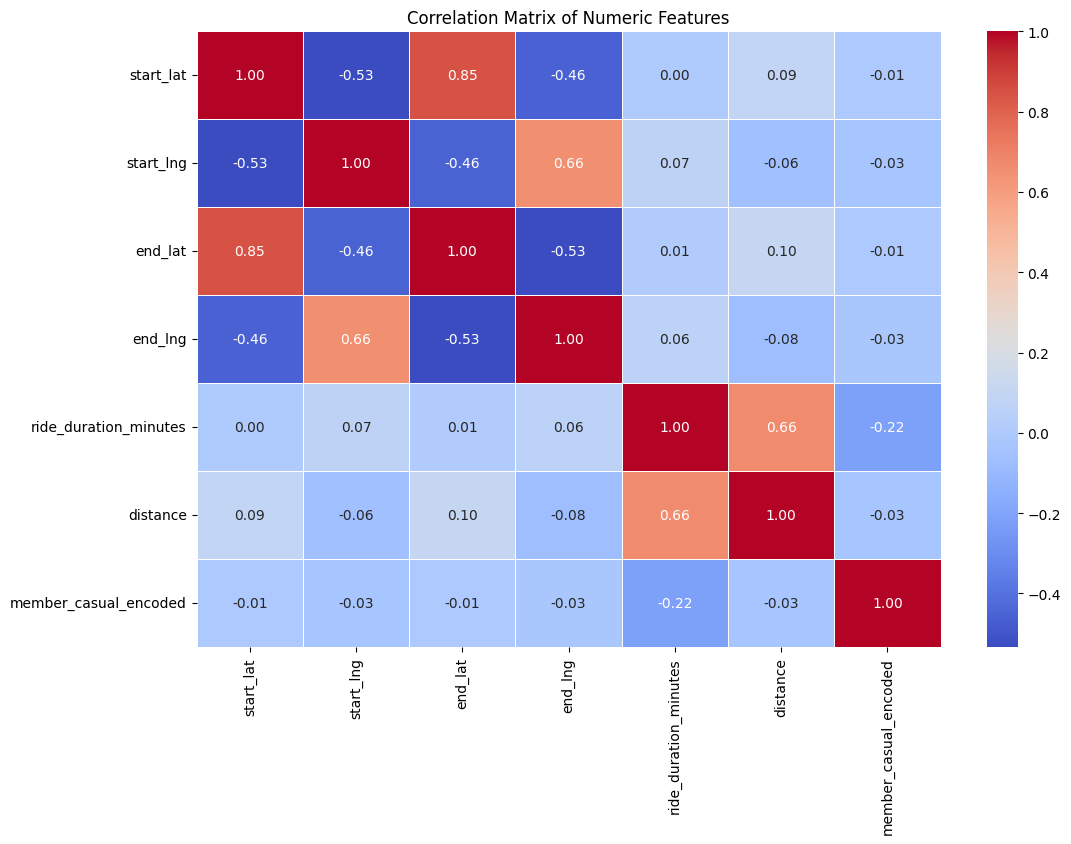

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Add titles and labels
plt.title('Correlation Matrix of Numeric Features')
plt.show()


### Frequency analysis


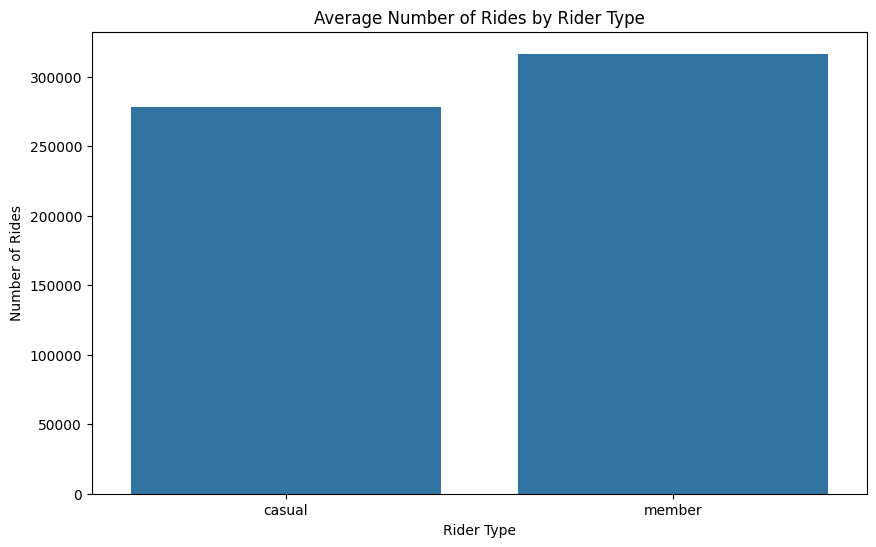

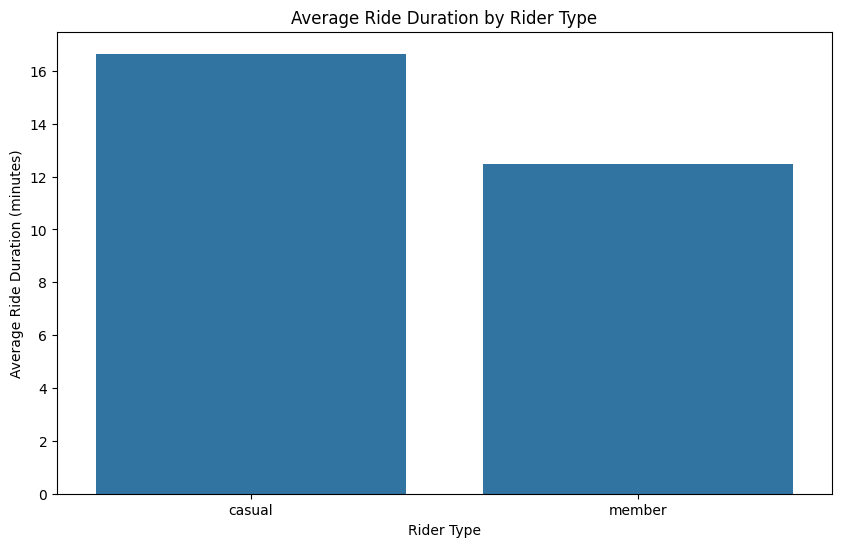

In [7]:

# Calculate frequency of rides for each rider type
ride_frequency = df.groupby('member_casual')['ride_id'].count().reset_index(name='ride_count')

# Calculate the average ride duration for each rider type
average_duration = df.groupby('member_casual')['ride_duration_minutes'].mean().reset_index(name='average_duration')

# Merge the two dataframes on 'member_casual'
frequency_duration_df = pd.merge(ride_frequency, average_duration, on='member_casual')

# Visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(x='member_casual', y='ride_count', data=frequency_duration_df)
plt.xlabel('Rider Type')
plt.ylabel('Number of Rides')
plt.title('Number of Rides by Rider Type')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='member_casual', y='average_duration', data=frequency_duration_df)
plt.xlabel('Rider Type')
plt.ylabel('Average Ride Duration (minutes)')
plt.title('Average Ride Duration by Rider Type')
plt.show()

# If you want to overlay frequency and duration, consider a scatter plot or advanced multivariate plots


### Peak times/days analysis

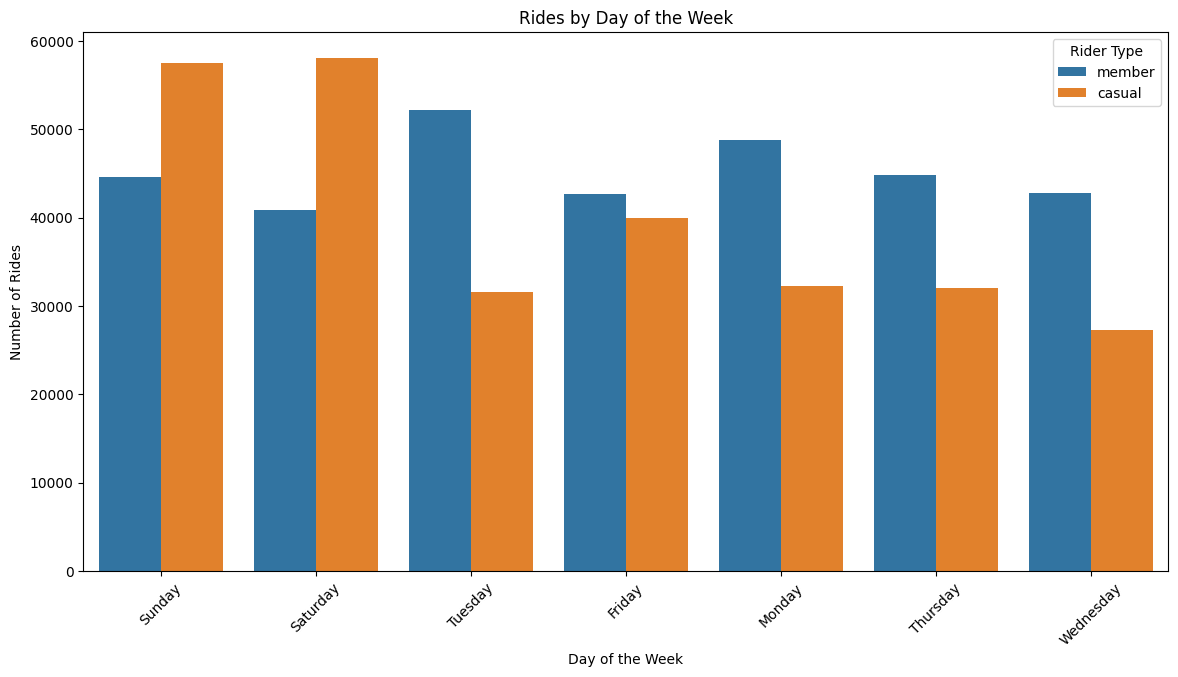

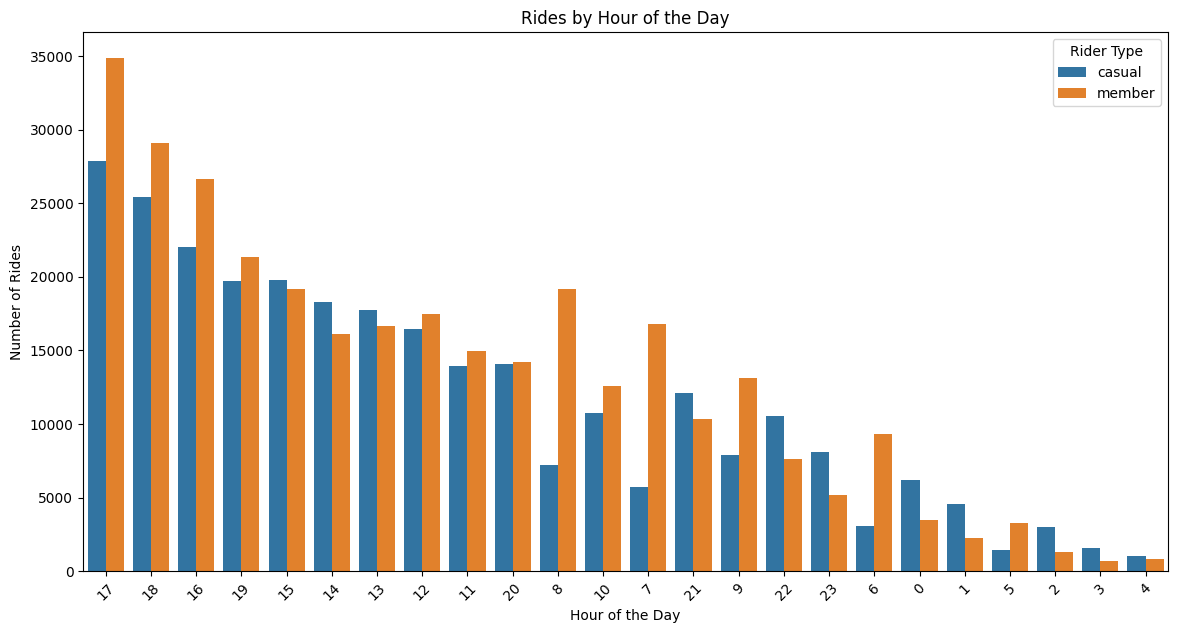

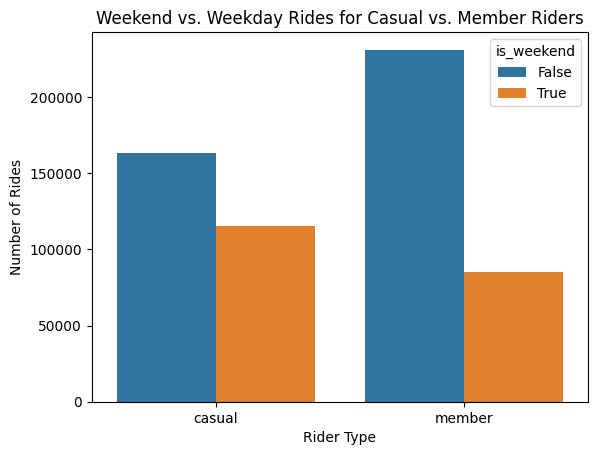

In [8]:
# Extract day of week and hour from 'started_at'
df['start_day_of_week'] = df['started_at'].dt.day_name()
df['start_hour'] = df['started_at'].dt.hour

# For simplicity, let's create a function to plot our findings
def plot_temporal_patterns(dataframe, time_component, title, xlabel, ylabel):
    plt.figure(figsize=(14, 7))
    sns.countplot(data=dataframe, x=time_component, hue='member_casual', order=dataframe[time_component].value_counts().index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)  # Rotate labels for better readability if needed
    plt.legend(title='Rider Type')
    plt.show()

# Plot the distribution over days of the week
plot_temporal_patterns(df, 'start_day_of_week', 'Rides by Day of the Week', 'Day of the Week', 'Number of Rides')

# Plot the distribution over hours of the day
plot_temporal_patterns(df, 'start_hour', 'Rides by Hour of the Day', 'Hour of the Day', 'Number of Rides')

# To specifically look at weekend vs. weekday usage
df['is_weekend'] = df['start_day_of_week'].isin(['Saturday', 'Sunday'])
weekend_weekday_comparison = df.groupby(['member_casual', 'is_weekend'])['ride_id'].count().reset_index(name='ride_count')
sns.barplot(data=weekend_weekday_comparison, x='member_casual', y='ride_count', hue='is_weekend')
plt.title('Weekend vs. Weekday Rides for Casual vs. Member Riders')
plt.xlabel('Rider Type')
plt.ylabel('Number of Rides')
plt.show()


### Geographical heatmap analsysis

In [9]:

# Create a base map using the average latitude and longitude of your data
map_center = df[['start_lat', 'start_lng']].mean().values.tolist()
m = folium.Map(location=map_center, zoom_start=13)  # Adjust zoom_start as needed

# Add heatmaps to the base map for casual and member riders separately
# For casual riders
casual_data = df[df['member_casual'] == 'casual'][['start_lat', 'start_lng']].dropna()
HeatMap(casual_data, radius=10).add_to(m)  # radius controls the smoothness of the points

# For member riders
member_data = df[df['member_casual'] == 'member'][['start_lat', 'start_lng']].dropna()
HeatMap(member_data, radius=10).add_to(m)  # radius controls the smoothness of the points

# Save it to an html file
m.save('heatmap.html')

# Save the map to an HTML file
file_path = './heatmap.html'  # or the correct path to your 'heatmap.html' file
m.save(file_path)

# Open the HTML file in the default web browser
webbrowser.open('file://' + os.path.realpath(file_path))

True

Not an active part of the analysis but just verifying the data is clean and makes sense. Looks like most of the hotspot areas are in the loop and places where office buildings are present and major turist areas

## Summary of EDA
- Ride Duration: Casual riders tend to have longer ride durations compared to members.
- Number of Rides: Members take more rides than casual riders.
- Day of the Week: There is variability in the number of rides by day, with weekends being particularly popular for casual riders.
- Hour of the Day: There are peak hours during which bike usage surges, and this pattern may vary between casual riders and members.
- Weekend vs. Weekday: Members appear to ride more on weekdays, while casual riders' usage doesn't drop as much on weekends.

## Machine Learning Model
Based on the EDA, we can infer the following characteristics about casual and member riders:

To predict whether a casual rider would be likely to convert to a member, a binary classification model is suitable. Here are some potential models based on the information gathered:

- Random Forest, Logistic regressions, decision tree classifier, gradient boosting

For each model, the features would include:

- Numerical Features: 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'ride_duration_minutes','distance'
- Categorical Feautures: 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id','start_day_of_week','rideable_type'
  
The target variable is whether the rider is a casual or a member. Before training the model, we will make sure to:

- Split the data into training and testing sets.
- Balance the classes
- Perform any final data cleaning or transformation required.

### Preparing the data for ML processing

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC

# print(df)

# Define the fraction of data to sample (0.1 for 10%)
fraction = 0.1

# Create a random sample of your data
df = df.sample(frac=fraction, random_state=42)

# Define your features and target variable
X = df.drop(['member_casual_encoded', 'ride_id','ride_duration'], axis=1)
y = df['member_casual_encoded']

# Drop the original datetime columns and the target variable from your features
X = X.drop(['started_at', 'ended_at', 'member_casual'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the categorical variables
categorical_features = ['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id','start_day_of_week','rideable_type']
X_train = pd.get_dummies(X_train, columns=categorical_features)
X_test = pd.get_dummies(X_test, columns=categorical_features)

# Ensure the test set has the same columns as the training set
X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

# Scale the numerical features
scaler = MinMaxScaler()
numerical_features = ['start_lat', 'start_lng', 'end_lat', 'end_lng', 'ride_duration_minutes','distance']
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Define a function that fits a model to the data and evaluates its performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy_score(y_test, predictions)}")
    print(f"Confusion Matrix:\n {confusion_matrix(y_test, predictions)}")
    print(f"Classification Report:\n {classification_report(y_test, predictions)}")


### Evaluating different Models

In [11]:
# Evaluate multiple models
evaluate_model(RandomForestClassifier(), X_train, X_test, y_train, y_test)

Model: RandomForestClassifier
Accuracy: 0.662242755144897
Confusion Matrix:
 [[3352 2206]
 [1815 4532]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.60      0.63      5558
           1       0.67      0.71      0.69      6347

    accuracy                           0.66     11905
   macro avg       0.66      0.66      0.66     11905
weighted avg       0.66      0.66      0.66     11905



In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline that scales the data and then runs logistic regression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

evaluate_model(pipeline, X_train, X_test, y_train, y_test)


Model: Pipeline
Accuracy: 0.6641747165056698
Confusion Matrix:
 [[3119 2439]
 [1559 4788]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.56      0.61      5558
           1       0.66      0.75      0.71      6347

    accuracy                           0.66     11905
   macro avg       0.66      0.66      0.66     11905
weighted avg       0.66      0.66      0.66     11905



In [13]:
evaluate_model(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

Model: DecisionTreeClassifier
Accuracy: 0.6113397732045359
Confusion Matrix:
 [[3258 2300]
 [2327 4020]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.59      0.58      5558
           1       0.64      0.63      0.63      6347

    accuracy                           0.61     11905
   macro avg       0.61      0.61      0.61     11905
weighted avg       0.61      0.61      0.61     11905



In [14]:
evaluate_model(GradientBoostingClassifier(), X_train, X_test, y_train, y_test)

Model: GradientBoostingClassifier
Accuracy: 0.6732465350692987
Confusion Matrix:
 [[3187 2371]
 [1519 4828]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.57      0.62      5558
           1       0.67      0.76      0.71      6347

    accuracy                           0.67     11905
   macro avg       0.67      0.67      0.67     11905
weighted avg       0.67      0.67      0.67     11905



### Improving gradient boosting

A quick summary of the results

**Random Forest Classifier:** This model achieved an accuracy of approximately 66.2%. The precision, recall, and f1-score for predicting casual riders (0) were 0.65, 0.60, and 0.63 respectively. For predicting members (1), these metrics were 0.67, 0.71, and 0.69 respectively.

**Logistic Regression:** This model achieved an accuracy of approximately 66.4%. The precision, recall, and f1-score for predicting casual riders were 0.67, 0.56, and 0.61 respectively. For predicting members, these metrics were 0.66, 0.75, and 0.71 respectively.

**Decision Tree Classifier:** This model achieved an accuracy of approximately 61.14%. The precision, recall, and f1-score for predicting casual riders were 0.58, 0.59, and 0.58 respectively. For predicting members, these metrics were 0.64, 0.63, and 0.63 respectively.

**Gradient Boosting Classifier:** This model achieved an accuracy of approximately 67.3%. The precision, recall, and f1-score for predicting casual riders were 0.68, 0.57, and 0.62 respectively. For predicting members, these metrics were 0.67, 0.76, and 0.71 respectively.

Based on these results, the Gradient Boosting Classifier model performed the best in terms of accuracy, now we proceed to imporve the model by searching for the best hyperparameters

In [34]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Assuming X_train and y_train are Pandas DataFrame and Series respectively
X_train_numpy = X_train.values
y_train_numpy = y_train.values

# Use a smaller subset for grid search (e.g., 5% of the data)
X_train_small, _, y_train_small, _ = train_test_split(X_train_numpy, y_train_numpy, test_size=0.95, random_state=42)

# Simplified parameter grid
param_grid = {
    'n_estimators': [200,300, 500],  # Further reduced
    'learning_rate': [0.1, 0.5, 1],  # Keeping these options
    'max_depth': [2, 3,4],         # Shallower trees for faster computation
    
}

# Create a GradientBoostingClassifier with early stopping parameters
gbc = GradientBoostingClassifier()

# Instantiate the grid search model with fewer CV folds
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data using the smaller subset
grid_search.fit(X_train_small, y_train_small)

# Get the best model
best_model = grid_search.best_estimator_

print(best_model)


GradientBoostingClassifier(max_depth=2, n_estimators=200)


In [35]:
evaluate_model(best_model, X_train, X_test, y_train, y_test)

Model: GradientBoostingClassifier
Accuracy: 0.6753464930701386
Confusion Matrix:
 [[3178 2380]
 [1485 4862]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.57      0.62      5558
           1       0.67      0.77      0.72      6347

    accuracy                           0.68     11905
   macro avg       0.68      0.67      0.67     11905
weighted avg       0.68      0.68      0.67     11905



## Result conclusion
We can say that with about 68% accuracy, the model could identify casual riders that might become members. The model used both categorical features (start_station_name, start_station_id, end_station_name, end_station_id, start_day_of_week, rideable_type) and numerical features (start_lat, start_lng, end_lat, end_lng, ride_duration_minutes, distance) to make these predictions.

The model’s precision for predicting casual riders (0) was 0.68 and for predicting members (1) was 0.67. This means that when the model predicted a rider to be a casual rider or a member, it was correct about 68% and 67% of the time, respectively.

The model’s recall for predicting casual riders was 0.57 and for predicting members was 0.72. This means that the model correctly identified 57% of all actual casual riders and 72% of all actual members.

The f1-score, which is a measure of the model’s accuracy that considers both precision and recall, was 0.62 for casual riders and 0.72 for members.

These results suggest that the model is more accurate at identifying members than casual riders. This could be useful for targeting marketing efforts towards those casual riders who are most likely to convert to members

# Final conclusion and discussion


### **Insights:**

**Ride Duration:**
Casual riders have longer ride durations than members, which might indicate more recreational use.
Members tend to have shorter, possibly more routine trips, consistent with regular commutes or errands.

**Frequency of Rides:**
Members take more rides overall, suggesting a routine or daily use pattern.
Casual riders' use spikes on weekends, hinting at leisure or non-routine use.

**Time and Day Patterns:**
Peak hours for bike usage could suggest times when casual riders are most likely to be riding.
Weekend popularity among casual riders indicates recreational or non-work-related activities.

### **Recommendations:**

**Leverage Model Predictions:** Use the predictions from the Gradient Boosting Classifier model to identify casual riders who are most likely to convert to members. Target these riders with specific marketing campaigns to encourage them to become members.

**Targeted Marketing:**
Implement targeted marketing campaigns during peak casual riding hours and on weekends, emphasizing the benefits of membership for frequent riders.
Highlight cost savings and convenience for members, which could be appealing for casual riders who use the service regularly.

**Membership Trials:**
Offer a one-week or one-month trial membership for casual riders to experience the benefits of being a member.
Provide incentives such as discounts or additional services during the trial period to encourage conversion.

**Loyalty Programs:**
Create a loyalty program where casual riders earn points for each ride, which can be redeemed for membership discounts.
Offer referral bonuses to members who refer casual riders who convert to full membership.

**Flexible Membership Plans:**
Introduce flexible membership plans that cater to casual riders who may not want to commit to a full year.
Consider offering weekend-only or off-peak hour memberships that align with the usage patterns of casual riders.

**Rider Engagement:**
Host events or guided tours on weekends to engage with casual riders and promote a sense of community.
Use these events to showcase the benefits of membership and provide on-the-spot sign-up opportunities with incentives.

**Feedback and Personalization:**
Collect feedback from casual riders to understand barriers to membership and address them in the service offerings.
Personalize communication and offers based on the riding patterns and preferences of casual riders.

**Infrastructure Improvements:**
Ensure bike availability during peak casual riding times and in locations popular among casual riders.
Improve the convenience and experience of bike rentals for casual riders to match the expectations of members.